## 심전도와 맥파를 이용한 머신러닝 기반 혈압 추정

---



### Code infomation

Created on Fri Aug 9 22:20:14 2019

Author : Kaintels (hanu)

Ver : 1.2.0

Environment : Anaconda 3 and Python 3.7.3 

### 데이터 세트 정보

1. 맥파(PPG) 신호 125Hz
2. 동맥혈압(ABP) 신호 125Hz
3. 심전도(ECG) 신호 125Hz

데이터는 kaggle.com에서 다운로드 하였으며, 실습의 용이성을 위해 MATLAB mat파일이 아닌 csv파일을 사용함.

## 파이썬 라이브러리 import 및 예제 데이터 불러오기

---



### 라이브러리 설치 (!pip install -r requirements.txt을 실행, 실행은 run 또는 shift-enter, 창을 닫을시 자동 삭제됨)

In [1]:
!pip install -r requirements.txt # 처음 설치 필수, 종료시 매번 초기화되는 구조로 창을 닫을 시 자동삭제됨

ERROR: Invalid requirement: '#'



In [2]:
%config IPCompleter.greedy=True

### 라이브러리 import

In [3]:
import numpy as np # 수치해석 라이브러리
import scipy # 신호처리 라이브러리
from scipy import signal
import pandas as pd # 데이터 관련 라이브러리 (데이터 불러오기)
import matplotlib # 도식화 라이브러리
import matplotlib.pyplot as plt # 도표 라이브러리
import io # 웹정보를 사용자에게 필요한 정보로 변환

### 중요 라이브러리 버전 확인

In [4]:
print(np.__version__)
print(scipy.__version__)
print(pd.__version__)
print(matplotlib.__version__)

1.16.3
1.2.1
0.24.2
3.0.3


### Google Colab setting

In [5]:
#from google.colab import files
#uploaded = files.upload() #

In [6]:
#data = pd.read_csv(io.BytesIO(uploaded['example.csv']), header=None) # 세로열의 0 = PPG, 1 = 혈압, 2 = ECG, header=None 옵션을 하지 않으면 0번 열이 헤더가 됨, 구글 colab 전용

### Local jupyter notebook setting

In [7]:
data = pd.read_csv("example.csv", header=None) # example.csv가 로컬파일에 직접 있고 주피터 노트북 전용

### 데이터 확인

In [8]:
data #데이터 확인

,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
0,1.73310,1.67060,1.61000,1.55520,1.50730,1.46630,1.433000,1.407600,1.389100,1.378300,...,1.69990,1.69110,1.68040,1.66960,1.65980,1.6491,1.64030,1.63440,1.62850,1.62460
1,69.31000,68.87000,68.38200,67.84400,67.30700,66.81900,66.281000,65.793000,65.305000,64.865000,...,138.23000,140.23000,142.04000,141.26000,137.30000,131.6300,126.26000,122.06000,118.89000,115.66000
2,0.18475,0.17986,0.17498,0.16471,0.14467,0.11975,0.084555,0.044477,0.004399,-0.025415,...,0.17986,0.19501,0.20479,0.21994,0.22972,0.2346,0.23998,0.24976,0.24487,0.24487


### 데이터 전치 및 제목 설정

In [9]:
data_T = data.T # 쉬운 전처리를 위해 Transpose(전치)힘

In [10]:
data_T.columns = ['PPG', 'BP', 'ECG'] # 데이터 열 제목 0,1,2을 각각 'PPG', 'BP', 'ECG'로 변경

In [11]:
data_T.head() # 상위 5개까지만 확인, 반대는 tail()

,PPG,BP,ECG
0,1.7331,69.310,0.18475
1,1.6706,68.870,0.17986
2,1.6100,68.382,0.17498
3,1.5552,67.844,0.16471
4,1.5073,67.307,0.14467


## 데이터 전처리
---

### 시간 설정

In [12]:
Timeset = len(data_T) # 길이 설정

In [13]:
#Timeset

In [14]:
Time = []
for i in range(0, Timeset,1):
  Time.append(i)  # 도식표를 그리기 위해 시간값이 있어야 하는데 시간값이 따로 없기때문에 데이터의 총 길이만큼 시간값을 만듬
#print(Time)

### 각 항목의 데이터 불러오기

In [15]:
PPG_dataFrame = data_T["PPG"]
BP_dataFrame = data_T["BP"]
ECG_dataFrame = data_T["ECG"]

In [16]:
rawPPG = np.array(PPG_dataFrame)
rawBP = np.array(BP_dataFrame)
rawECG = np.array(ECG_dataFrame)

In [17]:
print(rawPPG)
print(rawBP)
print(rawECG)

[1.7331 1.6706 1.61   ... 1.6344 1.6285 1.6246]
[ 69.31   68.87   68.382 ... 122.06  118.89  115.66 ]
[0.18475 0.17986 0.17498 ... 0.24976 0.24487 0.24487]


### 도식화

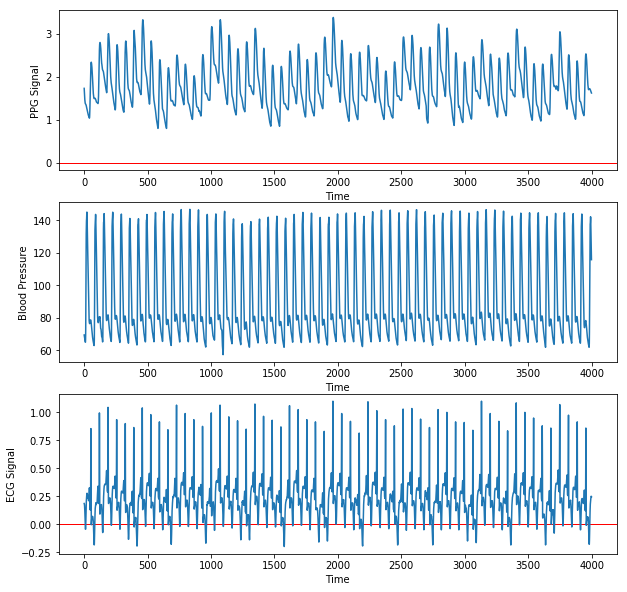

In [18]:
plt.figure(figsize=(10,10))
plt.subplot(311)
plt.xlabel("Time")
plt.ylabel("PPG Signal")
plt.axhline(y=0, color='r', linewidth=1)
plt.plot(Time,rawPPG)
plt.subplot(312)
plt.xlabel("Time")
plt.ylabel("Blood Pressure")
plt.plot(Time,rawBP)
plt.subplot(313)
plt.xlabel("Time")
plt.ylabel("ECG Signal")
plt.axhline(y=0, color='r', linewidth=1)
plt.plot(Time,rawECG)
plt.show() # 전처리 전 단계이므로 PPG와 ECG 전압의 진폭이 0에서 크게 벗어나있음

### 필터 설계

In [19]:
sample_rate = 125 # 샘플링 레이트

ppg_lowcut = 0.4
ppg_highcut = 4
ecg_lowcut = 1
ecg_highcut = 35 # 데이터 정보 및 차단 주파수 설정, Reference의 데이터 정보 및 보통 주로 사용되는 차단주파수를 사용함. 

In [20]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y # 버터워스 필터 함수

In [21]:
f_PPG = butter_bandpass_filter(rawPPG, lowcut=ppg_lowcut, highcut=ppg_highcut, fs=sample_rate, order=3) # 3차 버터워스 필터 설계
f_ECG = butter_bandpass_filter(rawECG, lowcut=ecg_lowcut, highcut=ecg_highcut, fs=sample_rate, order=3) # 3차 버터워스 필터 설계

### 필터링 후 재도식화

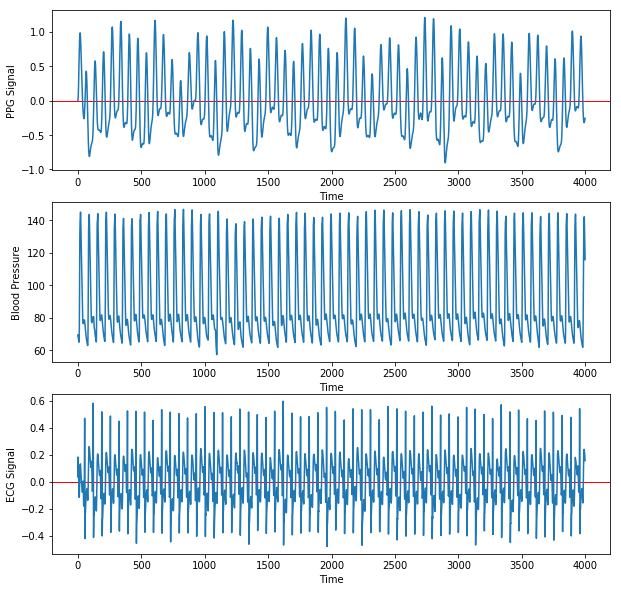

In [22]:
plt.figure(figsize=(10,10))
plt.subplot(311)
plt.xlabel("Time")
plt.ylabel("PPG Signal")
plt.axhline(y=0, color='r', linewidth=1)
plt.plot(Time,f_PPG)
plt.subplot(312)
plt.xlabel("Time")
plt.ylabel("Blood Pressure")
plt.plot(Time,rawBP)
plt.subplot(313)
plt.xlabel("Time")
plt.ylabel("ECG Signal")
plt.axhline(y=0, color='r', linewidth=1)
plt.plot(Time,f_ECG)
plt.show() # 필터 결과 PPG와 ECG의 전압값이 0 근처에서 진폭이 이루어짐

### 극댓값 검출

In [23]:
from scipy.signal import find_peaks # peak 검출 라이브러리

In [24]:
PPG_peaks, _ = find_peaks(f_PPG, height=0, distance=40) # 간단한 peak 검출 알고리즘
ECG_peaks, _ = find_peaks(f_ECG, height=-0.5, distance=60) # distance는 최소 거리 설정
BP_peaks, _ = find_peaks(rawBP, height=100,distance=60)#

### 극댓값 검출후 재도식화

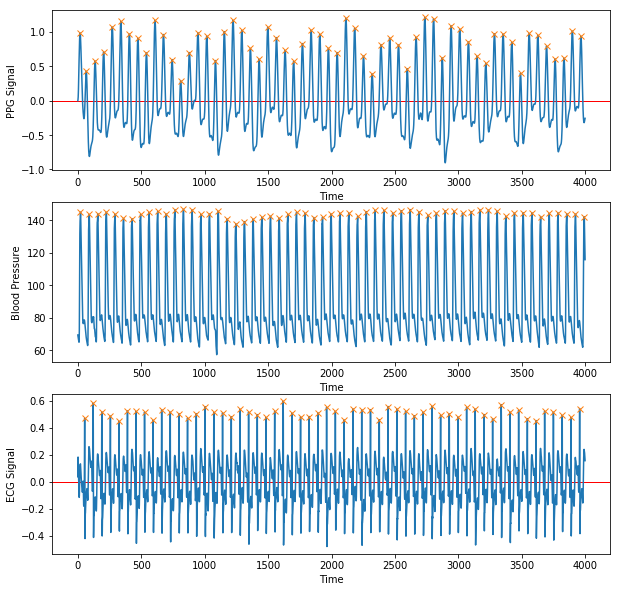

In [25]:
plt.figure(figsize=(10,10))
plt.subplot(311)
plt.xlabel("Time")
plt.ylabel("PPG Signal")
plt.axhline(y=0, color='r', linewidth=1)
plt.plot(Time,f_PPG)
plt.plot(PPG_peaks, f_PPG[PPG_peaks], "x")
plt.subplot(312)
plt.xlabel("Time")
plt.ylabel("Blood Pressure")
plt.plot(Time,rawBP)
plt.plot(BP_peaks, rawBP[BP_peaks], "x")
plt.subplot(313)
plt.xlabel("Time")
plt.ylabel("ECG Signal")
plt.axhline(y=0, color='r', linewidth=1)
plt.plot(Time,f_ECG)
plt.plot(ECG_peaks, f_ECG[ECG_peaks], "x")
plt.show() # 검출 완료

In [26]:
revisedPPG_peaks = PPG_peaks[1:] # ECG가 PPG 먼저 나오기 때문에 PPG의 첫번째값을 없앰

### 혈압을 예측하는 데 쓰이는 Pulse Arrival Time(PAT; ECG peak와 PPG 사이의 시간차)를 구함

In [27]:
PATp = np.subtract(revisedPPG_peaks,ECG_peaks) # PPG가 더 값이 크므로 PPG - ECG의 극댓값을 구함

In [28]:
print("length of PAT :", len(PATp))
print(PATp)

length of PAT : 58
[12 15 14 15 15 15 15 15 16 14 14 14 14 13 14 13 14 14 15 14 14 15 14 15
 13 15 15 15 14 14 13 13 14 13 14 13 13 13 14 14 14 13 15 14 14 14 14 14
 15 15 15 14 14 15 13 15 11 10]


In [29]:
SBP_max = rawBP[BP_peaks]
SBP_max = SBP_max[1:len(SBP_max)]# ECG peak와 PPG peak 사이에 SBP값이 있으므로 이것을 레이블로 설정, 마찬가지로 길이를 맞추기 위해 첫번째값을 없앰
print("length of SBP :", len(SBP_max))
print(SBP_max)

length of SBP : 58
[143.5  143.99 144.87 143.7  141.01 140.82 143.46 144.68 145.31 143.8
 146.48 146.63 146.29 143.5  143.8  145.41 140.72 137.74 139.06 140.62
 141.79 142.38 141.16 143.5  144.73 144.29 141.6  141.75 143.8  144.29
 144.48 142.28 145.16 146.04 146.14 144.48 145.75 146.43 145.16 143.11
 144.24 145.7  145.56 144.29 145.26 146.43 146.19 145.51 142.38 144.29
 144.48 144.48 142.19 144.14 144.48 143.94 143.7  142.04]


## 이상치 확인 및 제거

### 산포도화

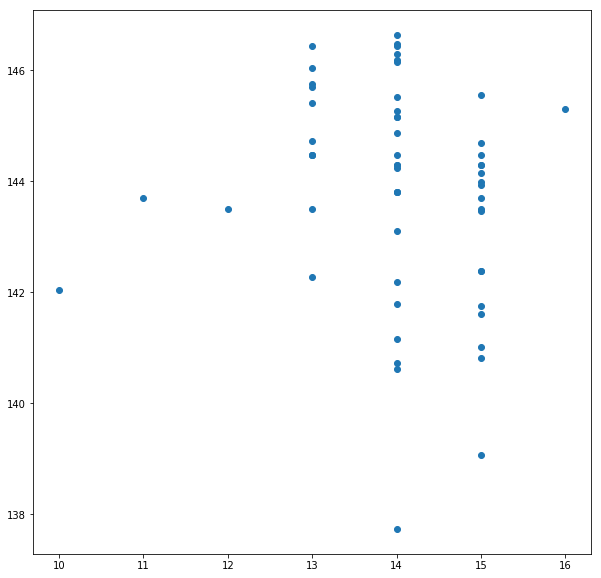

In [30]:
plt.figure(figsize=(10,10))
plt.scatter(PATp, SBP_max)
plt.show() # PAT 기반 혈압 추정은 예측에 영향을 주지 않게하는 outlier 제거 기법을 이용하여 혈압을 추정하기도 함. 동떨어져있는 데이터가 보임.

### Boxplot화 및 사분위수를 확인

#### o점은 이상치, 위부분 - 까지는  max, 아래 -부분까지는 min, 주황색은 평균값

##### 참고 : https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85

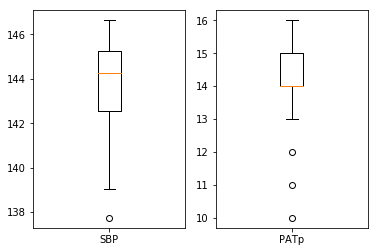

In [31]:
plt.subplot(121)
plt.boxplot(SBP_max, labels=['SBP'])
plt.subplot(122)
plt.boxplot(PATp, labels=['PATp'])
plt.show() # 결과 주황색선(평균)에 비해서 SBP는 137~139, PAT는 10~12정도가 이상치라는 것을 확인할수가 있었음. 공통된 값에 해당하는 부분을 지울 예정.

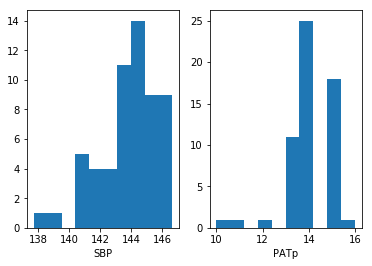

In [32]:
plt.subplot(121)
plt.hist(SBP_max)# 히스토그램으로도 확인
plt.xlabel('SBP')
plt.subplot(122)
plt.hist(PATp) # 히스토그램으로도 확인
plt.xlabel('PATp')
plt.show()

In [33]:
print(PATp)
print(SBP_max)

[12 15 14 15 15 15 15 15 16 14 14 14 14 13 14 13 14 14 15 14 14 15 14 15
 13 15 15 15 14 14 13 13 14 13 14 13 13 13 14 14 14 13 15 14 14 14 14 14
 15 15 15 14 14 15 13 15 11 10]
[143.5  143.99 144.87 143.7  141.01 140.82 143.46 144.68 145.31 143.8
 146.48 146.63 146.29 143.5  143.8  145.41 140.72 137.74 139.06 140.62
 141.79 142.38 141.16 143.5  144.73 144.29 141.6  141.75 143.8  144.29
 144.48 142.28 145.16 146.04 146.14 144.48 145.75 146.43 145.16 143.11
 144.24 145.7  145.56 144.29 145.26 146.43 146.19 145.51 142.38 144.29
 144.48 144.48 142.19 144.14 144.48 143.94 143.7  142.04]


In [34]:
PAT_SBPdata = {'PAT': PATp,'SBP': SBP_max}
PSdf = pd.DataFrame(PAT_SBPdata)

### 이상치 제거

In [35]:
PSdf_removel = PSdf[PSdf.PAT > 12] # PATp가 12보다 큰 값만 불러오기

In [36]:
PSdf_removel_second = PSdf_removel[PSdf_removel.SBP > 141] # SBP_MAX가 141보다 큰 값만 불러오기

In [37]:
#PSdf_removel_second # 데이터 확인

### Boxplot화 및 사분위수를 재확인

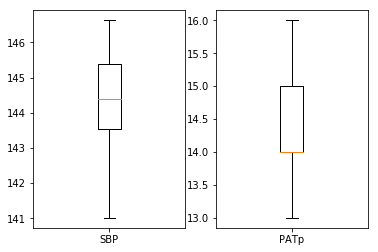

In [38]:
PAT_dataFrame = PSdf_removel_second["PAT"]
SBP_dataFrame = PSdf_removel_second["SBP"]
plt.subplot(121)
plt.boxplot(SBP_dataFrame, labels=['SBP'])
plt.subplot(122)
plt.boxplot(PAT_dataFrame, labels=['PATp'])
plt.show() # 이상치가 제거

### 재 산포도화

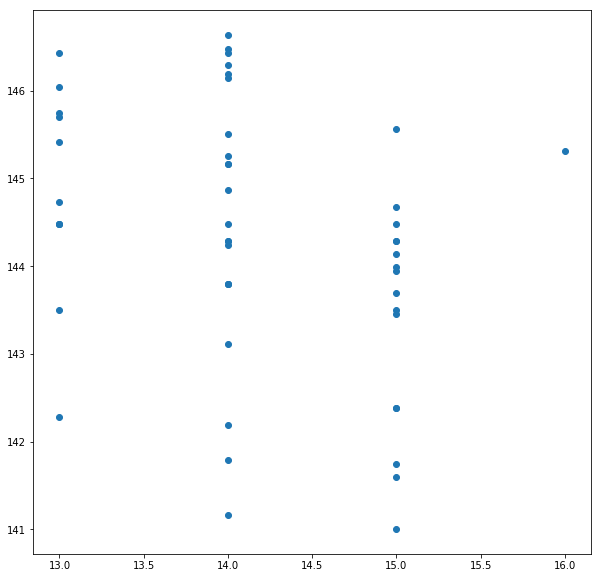

In [39]:
plt.figure(figsize=(10,10))
plt.scatter(PAT_dataFrame, SBP_dataFrame)
plt.show()

## 머신러닝 (선형회귀)
---

In [40]:
from sklearn.model_selection import train_test_split # 테스트 트레인 데이터 나누는 라이브러리
import sklearn
from sklearn.linear_model import LinearRegression # 선형회귀 라이브러리
from sklearn.metrics import mean_squared_error # 정답과 예측값과의 오차 계산

### 중요 라이브러리 버전 확인

In [41]:
print(sklearn.__version__)

0.21.1


In [42]:
PATarr = np.array(PAT_dataFrame)
SBParr = np.array(SBP_dataFrame)
PATarr = PATarr.reshape(-1,1) # 회귀를 위해 차원 맞춤
SBParr = SBParr.reshape(-1,1) # 회귀를 위해 차원 맞춤

### 학습 및 테스트 데이터 분할

In [43]:
X_train, X_test, Y_train, Y_test = train_test_split(PATarr, SBParr, test_size=0.3, random_state=0)

# train : test 비율은 7 : 3로, 예측 결과가 매번 다르지 않게 랜덤시드 고정 (test train 위치 고정)

### 학습 및 테스트 데이터 확인

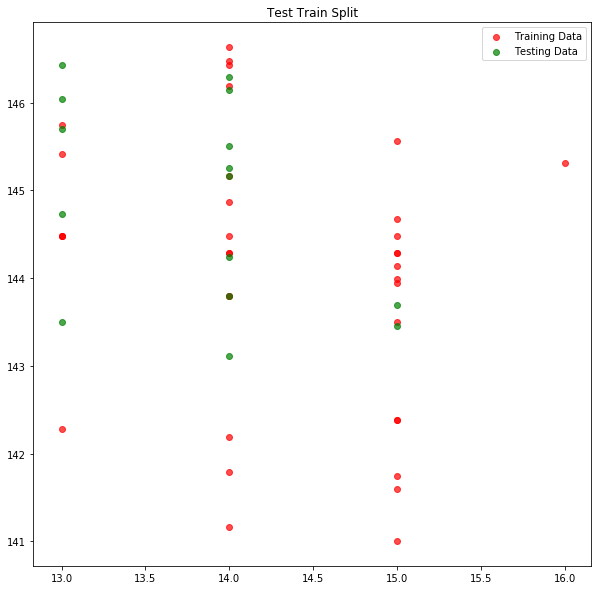

In [44]:
plt.figure(figsize=(10, 10))
plt.scatter(X_train, Y_train, label='Training Data', color='r', alpha=.7)
plt.scatter(X_test, Y_test, label='Testing Data', color='g', alpha=.7)
plt.legend() # 산포도 정보
plt.title("Test Train Split")
plt.show()

### 예측 및 도식화

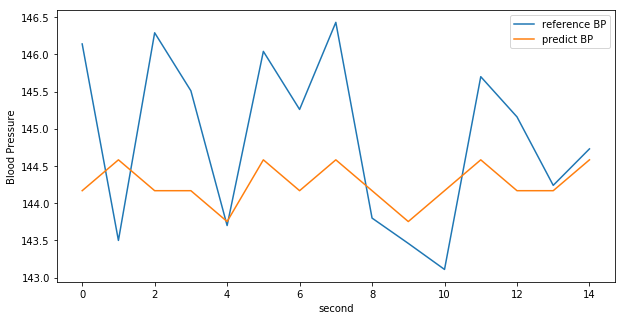

In [45]:
model = LinearRegression()

model.fit(X_train,Y_train)
predict = model.predict(X_test)

plt.figure(figsize=(10,5))

plt.plot(Y_test,label='reference BP')
plt.plot(predict,label ='predict BP')
plt.xlabel('second')
plt.ylabel('Blood Pressure')
plt.legend()
plt.show()

### 평균 제곱근 편차(Root Mean Squared Error) 구하기

##### 참고 : https://ko.wikipedia.org/wiki/%ED%8F%89%EA%B7%A0_%EC%A0%9C%EA%B3%B1%EA%B7%BC_%ED%8E%B8%EC%B0%A8

#### 임의의 n개의 값에 대한 제곱평균제곱근(root mean square)은 다음과 같은 식으로 정의된다.

$$ \sqrt{\frac{1}{n}\sum_{k=1}^{n}} x_{k}^2$$

In [46]:
rmse =np.sqrt(mean_squared_error(Y_test,predict))
print('RMSE value is :', rmse) # 실제 값과의 오차가 1.2정도 차이남. 추세선은 추정을 할 정도로는 그려짐.

RMSE value is : 1.2025889753649608


### 상관 계수 구하기

##### 참고 : https://ko.wikipedia.org/wiki/%EC%83%81%EA%B4%80_%EB%B6%84%EC%84%9D

In [47]:
pred_mean = np.mean(predict) #평균값 구하기
ans_mean = np.mean(Y_test) #평균값 구하기

averg = np.ones(len(predict)+1)
avergA = averg * pred_mean
avergB = averg * ans_mean
sss = (predict-avergA)*(Y_test-avergB) # 각 편수에서 평균값을 빼고 곱하기
sssS = sum(sss) # 각 변수들의 값을 합산
ppp = np.std(predict) * np.std(Y_test) #표준편차의 곱을 구하기
cor = sssS /((len(predict)) * ppp) #상관계수 구하기
corr = cor[0]
print('\ncorr : ', corr) # 상관관계는 0.42정도.


corr :  0.4233183692334272


In [48]:
cor = np.corrcoef(predict.reshape(15),Y_test.reshape(15))[1,0] # numpy로 구해보기
cor

0.4233183692334273

### 상관 계수 도식화

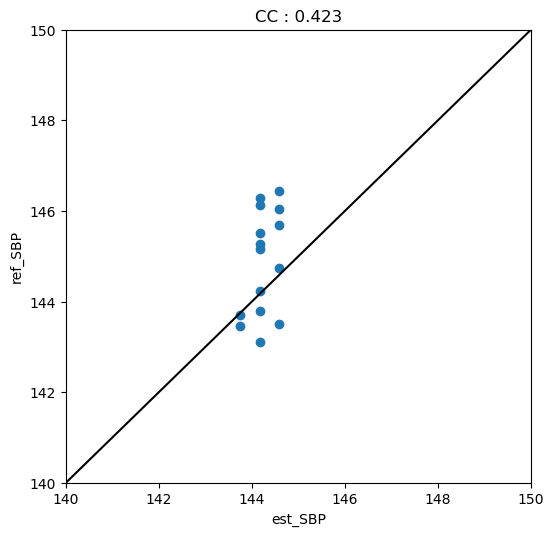

In [49]:
d_ans = Y_test

x = [a for a in range(160)]
y = [b for b in range(160)]

cor_print = corr
plt.figure(figsize=(6,6), dpi = 100)
plt.scatter(predict, d_ans)

plt.xlim(140, 150)
plt.ylim(140, 150)
plt.title('CC : ' + str(round(cor,3)))
plt.xlabel("est_SBP")
plt.ylabel("ref_SBP")
    
plt.plot(x,y, 'k')
plt.show()

## 지금까지 사용한 변수 확인

In [50]:
whos

Variable                 Type                Data/Info
------------------------------------------------------
BP_dataFrame             Series              0        69.310\n1       <...>gth: 4000, dtype: float64
BP_peaks                 ndarray             59: 59 elems, type `int64`, 472 bytes
ECG_dataFrame            Series              0       0.184750\n1      <...>gth: 4000, dtype: float64
ECG_peaks                ndarray             58: 58 elems, type `int64`, 464 bytes
LinearRegression         ABCMeta             <class 'sklearn.linear_mo<...>l.base.LinearRegression'>
PAT_SBPdata              dict                n=2
PAT_dataFrame            Series              1     15\n2     14\n3    <...>\nName: PAT, dtype: int64
PATarr                   ndarray             50x1: 50 elems, type `int64`, 400 bytes
PATp                     ndarray             58: 58 elems, type `int64`, 464 bytes
PPG_dataFrame            Series              0       1.7331\n1       1<...>gth: 4000, dtype: float64
PP

## Reference
---

[1] M. Kachuee, M. M. Kiani, H. Mohammadzade, M. Shabany, Cuff-Less High-Accuracy Calibration-Free Blood Pressure Estimation Using Pulse Transit Time, IEEE International Symposium on Circuits and Systems (ISCAS'15), 2015.

[2] M. Kachuee, M. M. Kiani, H. Mohammadzadeh, M. Shabany, Cuff-Less Blood Pressure Estimation Algorithms for Continuous Health-Care Monitoring, IEEE Transactions on Biomedical Engineering, 2016.